### Expaction-Maximization

通常在一些机器学习应用里，我们都是给定一些数据，利用极大似然估计出模型的参数。但在某些情况下我们有一部分数据是未知的，模型也是未知的，这个时候可以通过 EM 算法来估计出隐含数据和模型参数、

理解 EM 算法需要理解两个过程，一个过程是已知所有数据，进而估计模型参数；另一个过程是已知模型和一部分数据，计算出隐含数据。

EM 的做法是启发式的、迭代式的：

1. 随机假定一个模型，然后使用这个模型计算出隐含数据 （E step）
2. 基于隐含数据，利用极大似然估计出新的模型参数（M step）

这两步骤不断迭代，直至收敛。

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# data preparation
cluster1 = np.random.multivariate_normal([1, 2], [[1, 0], [0, 1]], 50)
cluster2 = np.random.multivariate_normal([3, 4], [[1, 0], [0, 1]], 50)
cluster3 = np.random.multivariate_normal([7, 7], [[1, 0], [0, 1]], 50)
data = np.vstack([cluster1, cluster2, cluster3])

In [3]:
def plot(data):
    data = np.array(data)
    plt.scatter(data[:, 0], data[:, 1])

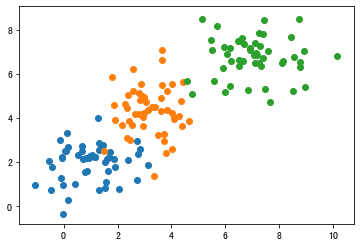

In [4]:
for c in [cluster1, cluster2, cluster3]:
    plot(c)

### KMeans

In [5]:
class KMeans:
    def __init__(self, k, max_try=5, max_iters=100, tol=1e-8):
        self.k = k
        self.max_try = max_try
        self.max_iters = max_iters
        self.tol = tol
        
    def fit(self, x):
        best_score, best_res = None, None
        for _ in range(self.max_try):
            score, res = self._fit_one_round(x)
            if not best_score or score > best:
                best_score = score
                best_res = res
        return res
    
    def _fit_one_round(self, x):
        centers = x[np.random.choice(range(len(x)), size=self.k)]
        for i in range(self.max_iters):
            # E step
            cls_dict = defaultdict(list)
            for sample in x:
                c = np.argmin([self._dist(sample, center) for center in centers])
                cls_dict[c].append(sample)
            # M step
            new_centers = np.array([np.mean(samples, 0) for samples in cls_dict.values()])
            dist = self._dist(centers, new_centers)
            if dist < self.tol:
                break
            centers = new_centers
        return -dist, (new_centers, cls_dict)
    
    def _dist(self, a, b):
        return np.mean((a - b) ** 2)

In [6]:
kmeans = KMeans(k=3)
centers, cls_dict = kmeans.fit(data)

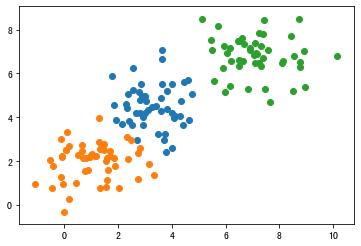

In [7]:
for samples in cls_dict.values():
    plot(samples)

### Gaussian Mixture Model

In [44]:
class GM:
    def __init__(self, k, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        
    def fit(self, x):
        models = self._init_models()
        for i in range(self.max_iters):
            # E step
            probs_matrix = []
            for sample in x:
                probs = [self._get_probs(sample, model) for model in models]
                probs_matrix.append(probs)
            probs_matrix = np.array(probs_matrix)
            # M step
            new_models = []
            for i in range(len(models)):
                new_models.append(self._update_model(probs_matrix[:, i:i + 1], x))
            
            models = new_models
        centers = self._get_centers(probs_matrix, models)
        return centers, probs_matrix
    
    def _init_models(self):
        models = []
        for i in range(self.k):
            mean = np.array([1., 1.])
            cov = np.array([[1., 0.], [0., 1.]])
            models.append((mean, cov))
        return models
    
    def _get_probs(self, sample, model):
        mean, cov = model
        return np.exp(-0.5 * (sample - mean).T.dot(np.linalg.inv(cov + 1e-8 * np.eye(len(cov)))).dot(sample - mean)) / ((2 * np.pi) ** 2 * np.linalg.det(cov)) ** 0.5

    def _update_model(self, p, x):
        mean = np.mean(p * x, 0)
        cov = np.cov(p * x, rowvar=0)
        return (mean, cov)
    
    def _get_centers(self, probs, models):
        return np.array([models[np.argmax(p)][0] for p in probs])

In [45]:
gm = GM(k=3)
centers, _ = gm.fit(data)

/Users/abbo/anaconda3/envs/lab/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
